# **Relatório econometria - ENADE**

### Preparando o ambiente

* Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

* Selecionando dados

In [2]:
caminho = './bases/microdados-enade-2018econ.csv'
df = pd.read_csv(caminho, sep='\t', encoding='utf-16')
df.shape

(9582, 137)

### Delimitando a pesquisa

* Estudantes da UFPR

In [3]:
df_ufpr = df[df['Co Ies'] == 571]

* Confirmando turno da graduação com código do curso no Enade

In [4]:
df_ufpr.groupby('Co Turno Graduacao')['Co Curso'].unique()

Co Turno Graduacao
1    [12571]
4    [49468]
Name: Co Curso, dtype: object

* Apenas estudantes com presença e resultados válidos na prova

In [5]:
df_ufpr = df_ufpr[df_ufpr['Tp Pres'] == 555]

* Selecionando colunas relevantes para o projeto

In [6]:
colunas_a_manter = ['Co Ies', 'Co Grupo', 'Co Curso', 'Co Turno Graduacao', 'Tp Pres', 'Nt Ger', 'Qe I04', 'Qe I05', 'Qe I09', 'Qe I10']
df_ufpr = df_ufpr[colunas_a_manter].copy()

### Tratando os dados

* Transformando as colunas de escolaridade e trabalho em binárias

In [7]:
colunas_escolaridade = ['Qe I04', 'Qe I05']

mapeamento_escolaridade = {
    'A': 0,
    'B': 0,
    'C': 0,
    'D': 0,
    'E': 1,
    'F': 1,
}

mapeamento_trabalho = {
    'A': 0,
    'B': 1,
    'C': 1,
    'D': 1,
    'E': 1,
    'F': 1,
}

df_ufpr[colunas_escolaridade] = df_ufpr[colunas_escolaridade].replace(mapeamento_escolaridade)
df_ufpr['Qe I10'] = df_ufpr['Qe I10'].replace(mapeamento_trabalho)

* Alterando type da coluna de notas gerais para float

In [8]:
df_ufpr['Nt Ger'] = df_ufpr['Nt Ger'].apply(lambda x: x.replace(',', ''))
df_ufpr['Nt Ger'] = df_ufpr['Nt Ger'].astype(np.float64) / 10

* Filtrando os grupos

In [9]:
df_ufpr['Pais_com_superior'] = df_ufpr['Qe I04'] + df_ufpr['Qe I05']
df_ufpr['Pais_com_superior'] = df_ufpr['Pais_com_superior'].apply(lambda x: 0 if x == 0 else 1)
df_ufpr.drop(columns=['Qe I04', 'Qe I05'], inplace=True)

In [10]:
df_ufpr.head()

,Co Ies,Co Grupo,Co Curso,Co Turno Graduacao,Tp Pres,Nt Ger,Qe I09,Qe I10,Pais_com_superior
719,571,13,12571,1,555,17.6,A,0,0
801,571,13,12571,1,555,40.2,A,0,0
802,571,13,12571,1,555,34.3,A,0,0
803,571,13,12571,1,555,3.7,A,0,0
804,571,13,12571,1,555,40.6,A,0,0


In [11]:
estudante_trabalha = (df_ufpr['Qe I10'] == 0)
estudante_nao_trabalha = (df_ufpr['Qe I10'] == 1)

nota_estudante_trabalha = df_ufpr[estudante_trabalha]['Nt Ger']
nota_estudante_nao_trabalha = df_ufpr[estudante_nao_trabalha]['Nt Ger']

In [12]:
dados_escolaridade_agrupados = df_ufpr.groupby('Pais_com_superior')['Qe I10']
porcentagens = dados_escolaridade_agrupados.value_counts(normalize=True) * 100

### Plotando gráficos para análise

* Escolaridade dos pais e trabalho

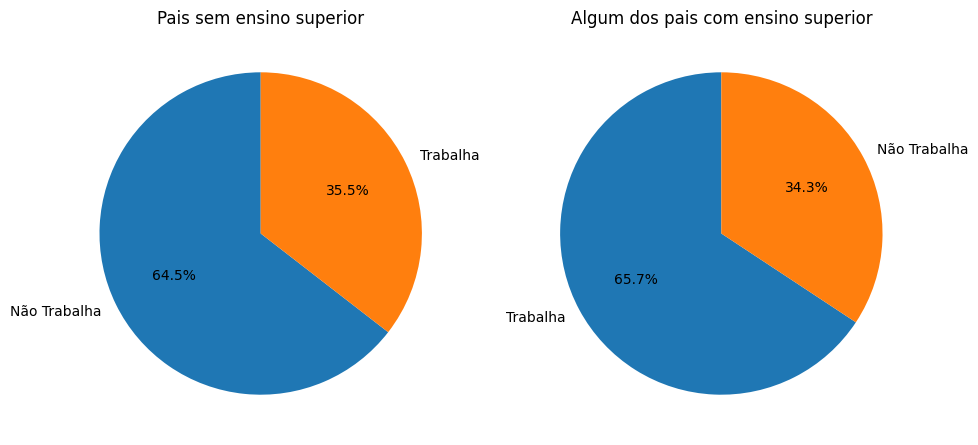

In [13]:
rotulos_variaveis = {
    0: 'Não Trabalha',
    1: 'Trabalha'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

porcentagens[0][0:2].rename(index=rotulos_variaveis).plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[0], label='')
axes[0].set_title('Pais sem ensino superior')

porcentagens[1][0:2].rename(index=rotulos_variaveis).plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[1], label='')
axes[1].set_title('Algum dos pais com ensino superior')

plt.tight_layout()
plt.show()



* box-plot para desempenho na nota geral de estudantes que trabalham/estudantes que não trabalham

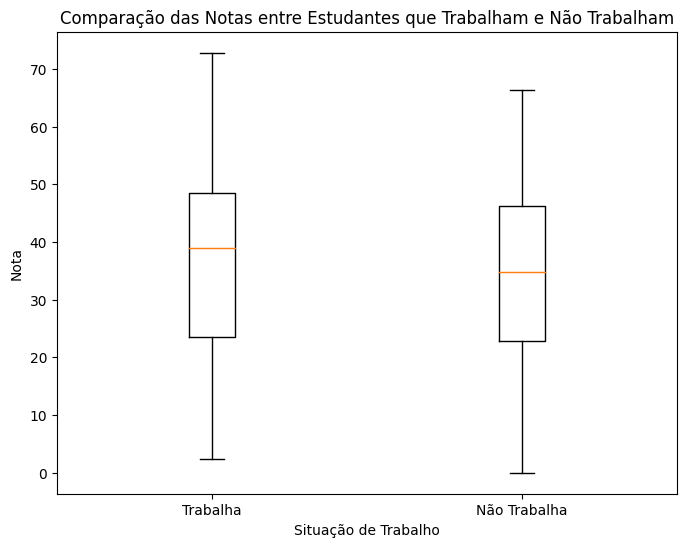

In [14]:
plt.figure(figsize=(8, 6))
plt.boxplot([nota_estudante_trabalha, nota_estudante_nao_trabalha], labels=['Trabalha', 'Não Trabalha'])
plt.title('Comparação das Notas entre Estudantes que Trabalham e Não Trabalham')
plt.xlabel('Situação de Trabalho')
plt.ylabel('Nota')
plt.show()

### Testes de hipótese

* Teste qui-quadrado para as variáveis binárias (Pais com ensino superior e Estudante trabalha?)

In [23]:
tabela_contingencia = pd.crosstab(df_ufpr['Pais_com_superior'], df_ufpr['Qe I10'])

chi2, p_value, dof, expected = stats.chi2_contingency(tabela_contingencia)


print('Tabela de Contingência:')
print(tabela_contingencia)
print('Valor p:', p_value)

Tabela de Contingência:
Qe I10              0   1
Pais_com_superior        
0                  40  22
1                  12  23
Valor p: 0.007926554548117455
